# Timeseries<a id="top"></a>

_Developed by Davíd Brakenhoff (Artesia) on July 19, 2019_
<hr>
This notebook explains the different options concerning timeseries in the waterbalans module.

## Contents

- [Types of Timeseries](#1)
    - [Constant](#1.1)
    - [ValueSeries](#1.2)
    - [FEWS](#1.3)
    - [KNMI](#1.4)
    - [Local (currently not implemented)](#1.5)
- [Methods for adding Timeseries](#2)
    - [`add_series_from_database()`](#2.1)
    - [`add_timeseries()`](#2.2)
    - [`wb.utils.add_timeseries_to_obj()`](#2.3)
- [Where are my timeseries?](#3)

Import the requisite modules

In [1]:
import numpy as np
import pandas as pd
import waterbalans as wb

## [Types of Timeseries](#top)<a id="1"></a>

There are several types of Timeseries in the waterbalans module. The description of each of these types is given below.

### [Constant](#top)<a id="1.1"></a>
The Constant Timeseries is, as the name implies, a timeseries with a constant value throughout the simulation. An example entry for adding a Constant Timeseries with the DataFrame containing series information is shown below:

In [2]:
df = pd.DataFrame(columns=['BakjeID', 'ClusterType', 'ParamType', 'Waarde', 'WaardeAlfa', 'StartDag'], index=[0],
                  data=[[1, "Qkwel", "Constant", 1.25, "", ""]])
df

,BakjeID,ClusterType,ParamType,Waarde,WaardeAlfa,StartDag
0,1,Qkwel,Constant,1.25,,


### [ValueSeries](#top)<a id="1.1"></a>

A ValueSeries is a timeseries with a constant value over a certain period. This can be used to differentiate between water levels in the winter and summer periods for example. ValueSeries are entered by adding multiple rows to the Timeseries DataFrame. 

Note that each year in the ValueSeries will be identical. Within a year there can be as many changes in the value as the user specificies

In [3]:
df = pd.DataFrame(columns=['BakjeID', 'ClusterType', 'ParamType', 'Waarde', 'WaardeAlfa', 'StartDag'], 
                  index=[0, 1],
                  data=[[1, "Qkwel", "ValueSeries", 1.25, "", "10-04"], 
                        [1, "Qkwel", "ValueSeries", -1.25, "", "10-10"]])
df

,BakjeID,ClusterType,ParamType,Waarde,WaardeAlfa,StartDag
0,1,Qkwel,ValueSeries,1.25,,10-04
1,1,Qkwel,ValueSeries,-1.25,,10-10


Convert data to DataFrame with column `StartDag` as the index and `Waarde` as the values

In [4]:
vs = df[["StartDag", "Waarde"]].set_index("StartDag")
vs

,Waarde
StartDag,
10-04,1.25
10-10,-1.25


Create a time_index to specify over which period of time the ValueSeries should be created. Create the ValueSeries. See the resulting plot below:

<AxesSubplot:>

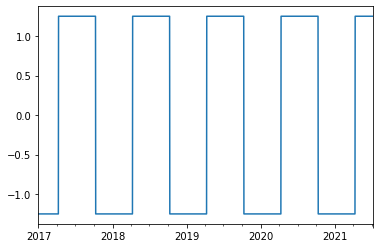

In [5]:
time_index = pd.date_range("2017-01-01", pd.datetime.now(), freq="D")
ts = wb.timeseries.create_block_series(vs, time_index)
ts.plot()

### [FEWS](#top)<a id="1.1"></a>

A FEWS timeseries is a timeseries that is picked up from the FEWS database. In order to do this, a few FEWS parameters have to be specified:
- filterId
- moduleInstanceId
- locationId
- parameterId

Example input

In [6]:
df = pd.DataFrame(columns=['BakjeID', 'ClusterType', 'ParamType', 'Waarde', 'WaardeAlfa', 'StartDag'], 
                  index=[0, 1],
                  data=[[-9999, "Neerslag", "FEWS", np.nan, 
                         "meteo_meetstation_KNMI|ImportCAW|66005cal|P.meting.dagcal", ""], 
                        [-9999, "Verdamping", "FEWS", np.nan, 
                         "meteo_meetstation_KNMI|ImportCAW|66002_VerdampingCAL|E.metingcal", ""]])
df

,BakjeID,ClusterType,ParamType,Waarde,WaardeAlfa,StartDag
0,-9999,Neerslag,FEWS,NaN,meteo_meetstation_KNMI|ImportCAW|66005cal|P.me...,
1,-9999,Verdamping,FEWS,NaN,meteo_meetstation_KNMI|ImportCAW|66002_Verdamp...,


Use `wb.timeseries.get_fews_series()` to load data from FEWS database (you need to have access to a FEWS database for this).

In [7]:
series = []
for fewsid in df.WaardeAlfa:
    try:
        ts = wb.timeseries.get_fews_series(fewsid, tmin="1995-12-31", tmax="2019-01-01")
        series.append(ts)
    except Exception as e:
        print("Failed on '{}'. Check if FEWS database is running!".format(fewsid))
        print(e)

Failed on 'meteo_meetstation_KNMI|ImportCAW|66005cal|P.meting.dagcal'. Check if FEWS database is running!
HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /FewsWebServices/fewspiservice?wsdl (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd566a67cd0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Failed on 'meteo_meetstation_KNMI|ImportCAW|66002_VerdampingCAL|E.metingcal'. Check if FEWS database is running!
HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /FewsWebServices/fewspiservice?wsdl (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd566590650>: Failed to establish a new connection: [Errno 111] Connection refused'))


Plot the timeseries:

(Note that there is apparently no evaporation coming out of the FEWS database after 2010 for some reason.)

In [8]:
ax = series[0].value.plot()
series[1].value.plot(ax=ax)

IndexError: list index out of range

### [KNMI](#top)<a id="1.1"></a>

Another timeseries type is KNMI, which can only be used for precipitation and evaporation. When the ParamType is set to KNMI, the module will attempt to download the timeseries for the station number provided in Waarde.

In [9]:
df = pd.DataFrame(columns=['BakjeID', 'ClusterType', 'ParamType', 'Waarde', 'WaardeAlfa', 'StartDag'], 
                  index=[0, 1],
                  data=[[1, "Neerslag", "KNMI", 240, "", ""], 
                        [1, "Verdamping", "KNMI", 260, "", ""]])
df

,BakjeID,ClusterType,ParamType,Waarde,WaardeAlfa,StartDag
0,1,Neerslag,KNMI,240,,
1,1,Verdamping,KNMI,260,,


Using `wb.timeseries.get_series` to download the KNMI data:

In [10]:
s = wb.timeseries.get_series("Neerslag", "KNMI", df.iloc[[0]], tmin='2017-01-01', tmax="2019-01-01")

/home/david/anaconda3/envs/waterbalans/lib/python3.7/site-packages/pastas/read/knmi.py:333: UserWarning: No KNMI data found
  warn('No KNMI data found')


KeyError: 'RD'

In [11]:
s.plot()

NameError: name 's' is not defined

### [Local (currently not implemented)](#top)<a id="1.1"></a>

The Local timeseries is a reference to a locally stored timeseries. This type can be seen in the CSV files exported from the database, but is not currently implemented in the waterbalans module. The reason is that this method overlaps with the functionality provided by `wb.utils.add_timeseries_to_obj` (which is much more efficient). Also there is data missing in the database to point the module to the right files to load.

<hr>

## [Methods for adding Timeseries](#top)<a id="2"></a>

There are several methods to add timeseries to an EAG or GAF object. These are described below

### [`add_series_from_database()`](#top)<a id="2.1"></a>

This method is used to parse the CSV file that is exported from the database that contains all of the information about timeseries to add to the EAG. 

Let's take a look at the docstring for this method:

In [12]:
help(wb.Eag.add_series_from_database)

Help on function add_series_from_database in module waterbalans.eag:

add_series_from_database(self, series, tmin, tmax, freq='D', fillna=False, method='append')
    Method to add timeseries based on a DataFrame containing
    information about the series. Series are described by one or more
    rows in the DataFrame with at least the following columns:
    
     - Bucket ID: ID of the bucket the series should be added to
     - SeriesType (unfortunately called ParamType at the moment): Origin or Type
       of the Series: e.g. FEWS, KNMI, Local, ValueSeries, Constant
     - ClusterType: Name of the parameter
    
    Parameters
    ----------
    series: pandas.DataFrame
    tmin: str or pandas.Timestamp, optional
    tmax: str or pandas.Timestamp, optional
    freq: str
    
    Notes
    -----
    
    Examples
    --------
    series = pd.read_csv("data\reeks_16088_2501-EAG-1.csv", delimiter=";",
                  decimal=",")
    eag.add_series_from_database(series)



This method basically combines the different strategies we used above to explore the different types of timeseries to parse a full DataFrame and add the series to the EAG or the specific Buckets. 

Where this timeseries ends up is defined by the `BakjeID` column of the DataFrame. 
- Entering the ID of specific bucket will add the timeseries to that buckets `Bucket.series` attribute. 
- Entering -9999 as the `BakjeID` will add the series to the `Eag.series` attribute.

Let's see this function in action by running a random Eag.

In [13]:
e = wb.run_eag_by_name("2250-EAG-2", csvdir="../../data/input_csv")

2021-07-08 18:10:10,399 | create_eag - INFO : Creating EAG object for '2250-EAG-2'
2021-07-08 18:10:10,434 | add_series_from_database - INFO : Parsing timeseries from database export and adding to EAG.
2021-07-08 18:10:10,441 | get_series - INFO : Adding Local timeseries 'Neerslag' for Bucket '-9999'.
2021-07-08 18:10:10,442 | get_series - INFO : Adding Local timeseries 'Uitlaat4' for Bucket '-9999'.
2021-07-08 18:10:10,443 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 1' for Bucket '-9999'.
2021-07-08 18:10:10,445 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 2' for Bucket '-9999'.
2021-07-08 18:10:10,446 | get_series - INFO : Adding Local timeseries 'Peil' for Bucket '-9999'.
2021-07-08 18:10:10,447 | get_series - INFO : Adding Local timeseries 'Gemaal2Debiet Pomp 2' for Bucket '-9999'.
2021-07-08 18:10:10,449 | get_series - INFO : Adding Local timeseries 'Gemaal3Debiet Pomp 2' for Bucket '-9999'.
2021-07-08 18:10:10,450 | get_series - INFO : A

Note the following section of the information printed to the console, which shows what this function is doing:
```
2019-07-19 16:51:58,128 | add_series_from_database - INFO : Parsing timeseries from database export and adding to EAG.
2019-07-19 16:52:00,035 | get_series - INFO : Adding FEWS timeseries 'Gemaal1Debiet Pomp 1': polder|Pompvolumes|60151_pomp_1|Vol.berekend.dag.
2019-07-19 16:52:01,506 | get_series - INFO : Adding FEWS timeseries 'Neerslag': meteo_meetstation_KNMI|ImportCAW|66005cal|P.meting.dagcal.
2019-07-19 16:52:02,874 | get_series - INFO : Adding FEWS timeseries 'Peil': polder|Statistiek|60151_onderbemaling|H.meting.gem.
2019-07-19 16:52:03,773 | get_series - INFO : Adding FEWS timeseries 'Verdamping': meteo_meetstation_KNMI|ImportCAW|66002_VerdampingCAL|E.metingcal.
```

### [`add_timeseries()`](#top)<a id="2.2"></a>

The `add_timeseries()` method is used to manually add timeseries to the Eag object. Timeseries can only be added to the Eag itself and not to the individual buckets.

Additionally, this function contains some options on how to deal with NaNs in the data.

In [14]:
help(wb.Eag.add_timeseries)

Help on function add_timeseries in module waterbalans.eag:

add_timeseries(self, series, name=None, tmin=None, tmax=None, freq='D', fillna=False, method=None)
    Method to add series directly to EAG. Series must contain volumes (so
    not divided by area). Series must be negative for water taken out of the
    EAG and positive for water coming into the EAG.
    
    Parameters
    ----------
    series: pandas.DataFrame or pandas.Series
    name: str, default None
        name of series to add, if not provided uses
        first column name in DataFrame or Series name
    tmin: str or pandas.Timestamp, optional
        start time for series to add to Eag
    tmax: str or pandas.Timestamp, optional
        end time for series to add to Eag
    freq: str, optional
        timestep of the series, should generally be left alone
    fillna: bool, default False
        if False, do not fill NaNs, if True fill NaNs according to method
    method: str or float
        if str (i.e. 'ffill') u

As the docstring shows, the NaNs can be filled by specifying a method (i.e. ffill, bfill, etc.) or passing a value which will be used to fill in the Nans.

From our earlier Eag simulation we can see the following output in the log pertaining to the `add_timeseries()` method:
```
2019-07-19 16:52:04,202 | add_timeseries - INFO : Adding timeseries 'Gemaal1' to EAG manually
2019-07-19 16:52:04,204 | add_timeseries - INFO : Filled 2187 NaN-values with '0.0' in series Gemaal1.
2019-07-19 16:52:04,211 | add_timeseries - INFO : Adding timeseries 'Peil' to EAG manually
2019-07-19 16:52:04,212 | add_timeseries - WARNING : Series Peil already present in EAG, overwriting data where not NaN!
2019-07-19 16:52:04,219 | add_timeseries - INFO : Adding timeseries 'q_cso' to EAG manually
2019-07-19 16:52:04,222 | add_timeseries - INFO : Filled 1572 NaN-values with '0.0' in series q_cso.
2019-07-19 16:52:04,231 | add_timeseries - INFO : Adding timeseries 'Neerslag' to EAG manually
2019-07-19 16:52:04,232 | add_timeseries - WARNING : Series Neerslag already present in EAG, overwriting data where not NaN!
2019-07-19 16:52:04,243 | add_timeseries - INFO : Adding timeseries 'Verdamping' to EAG manually
2019-07-19 16:52:04,245 | add_timeseries - WARNING : Series Verdamping already present in EAG, overwriting data where not NaN!
```

Note the warning that is given when a timeseries with the same name is already present in the Eag object. In this case, the series present in the Eag is updated with the values from the new series. If the new series contains NaNs, the value of the old series is kept.

### [`wb.utils.add_timeseries_to_obj()`](#top)<a id="2.3"></a>

This method is used to parse a DataFrame with timeseries data (one column per series) and add each series to the Eag object. It essentially wraps the previous `e.add_timeseries` method and deduces some information from the column names. 
- if `data_from_excel=False` (default option) the column names are assumed to be of the form `Name<#>|description`. In this case the name is used to determine how to parse the timeseries and add it to the Eag object.
- if `data_from_excel=True` the data must be identical to the data in the `uitgangspunten` sheet in the Excel balances (No columns can be removed and the order must be preserved). The column names are not used as the function knows the exact order the columns.

In [15]:
help(wb.utils.add_timeseries_to_obj)

Help on function add_timeseries_to_obj in module waterbalans.utils:

add_timeseries_to_obj(eag_or_gaf, df, tmin=None, tmax=None, overwrite=False, data_from_excel=False)
    Add timeseries to EAG or GAF. Only parses column names starting with
    'Neerslag', 'Verdamping', 'Inlaat', 'Uitlaat', 'Peil', or 'Gemaal'.
    
    Parameters
    ----------
    eag_or_gaf : waterbalans.Eag or waterbalans.Gaf
        An existing Eag or Gaf object
    df : pandas.DataFrame
        DataFrame with DateTimeIndex containing series to be added
    tmin : pandas.TimeStamp, optional
        start time for added series (the default is None, which
        attempts to pick up tmin from existing Eag or Gaf object)
    tmax : pandas.TimeStamp, optional
        end time for added series (the default is None, which
        attempts to pick up tmax from existing Eag or Gaf object)
    overwrite : bool, optional
        overwrite series if name already exists in Eag or Gaf object (the default is False)
    data_fr

Load the data from the `uitgangspunten` sheet (stored as a zipped pickle for quick reading). 

In [16]:
series = wb.utils.get_extra_series_from_pickle("../../data/excel_pklz/2250-EAG-2_series.pklz")

Add to our Eag object from earlier:

In [17]:
wb.utils.add_timeseries_to_obj(e, series, overwrite=True, data_from_excel=True)

IndexError: Item wrong length 17 instead of 20.

## [Where are my timeseries?](#top)<a id="3"></a>

So where do the timeseries go when they are added to the Eag? These are the options when adding a Timeseries:
- If a Bucket Id is specified they are added to the Bucket.series attribute
- If no Bucket Id is specified (-9999) they are added to the Eag

Once the simulation is run, timeseries get copied from the Eag to the relevant Buckets:
- When the simulation is performed, each bucket picks up the series it requires from the Eag.series. Generally these are precipitation (Neerslag) and evaporation (Verdamping).
- Eag series with name 'q_cso' is only used if there is MengRiool Bucket (combined sewer overflow bucket) and otherwise ignored.
- Eag series with name 'Peil', 'Inlaat#', 'Uitlaat#' are all added to the Water bucket.
- Eag series with name starting with 'Gemaal' are ignored in the simulation.
- All left-over unrecognized series names are added to the Water bucket as external forcing.

Let's take a look at the series in the Eag:

In [18]:
e.series.columns

Index(['Gemaal1', 'Peil', 'q_cso', 'Neerslag', 'Verdamping'], dtype='object')

Let's take a look at the series in each bucket:

In [19]:
for b in e.get_buckets():
    print("{0:<9s}  {1:>8d} {2}".format(b.name, b.idn, list(b.series.columns)))

Verhard    85000282 ['Qkwel', 'Neerslag', 'Verdamping']
Onverhard  85000283 ['Qkwel', 'Neerslag', 'Verdamping']
Drain      85000284 ['Qkwel', 'Neerslag', 'Verdamping']
Onverhard  85000288 ['Qkwel', 'Neerslag', 'Verdamping']
Drain      85000289 ['Qkwel', 'Neerslag', 'Verdamping']


And in the Water bucket (note that the 'q_cso' and 'gemaal' series were not added):

In [20]:
e.water.series.columns

Index(['Qwegz', 'Qkwel', 'Neerslag', 'Verdamping'], dtype='object')